timeout set in seconds as 3600
noFree_chuffed
free_chuffed
noFree_chuffed
free_chuffed


/tmp/ipykernel_2312629/3878270967.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = figure(figsize=(10, 10), dpi=80)


1.2298430046330864


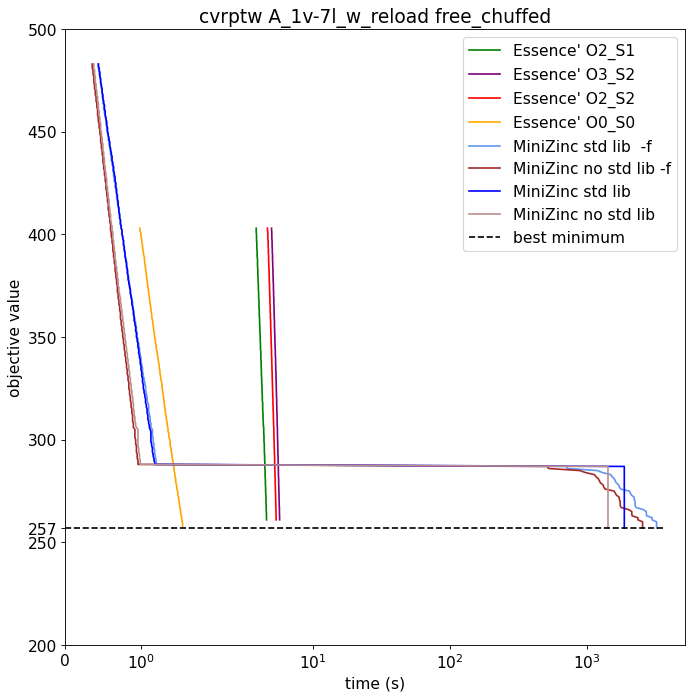

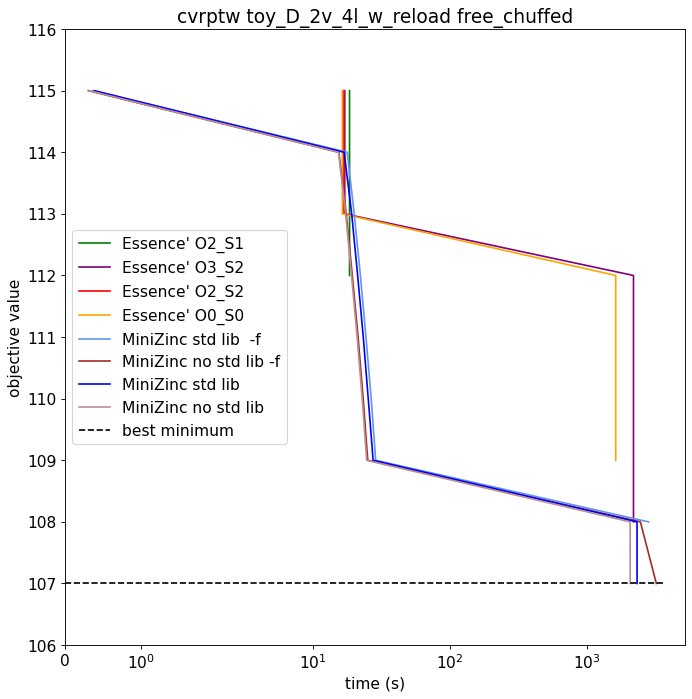

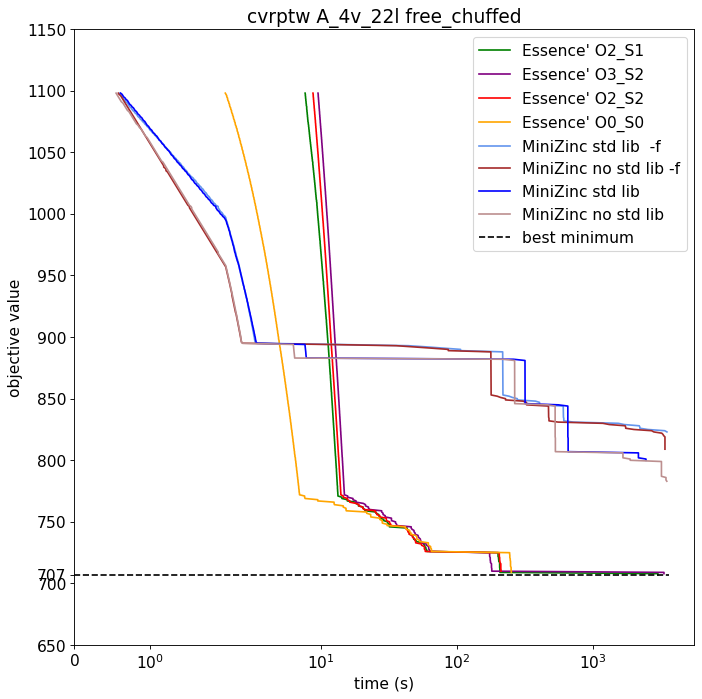

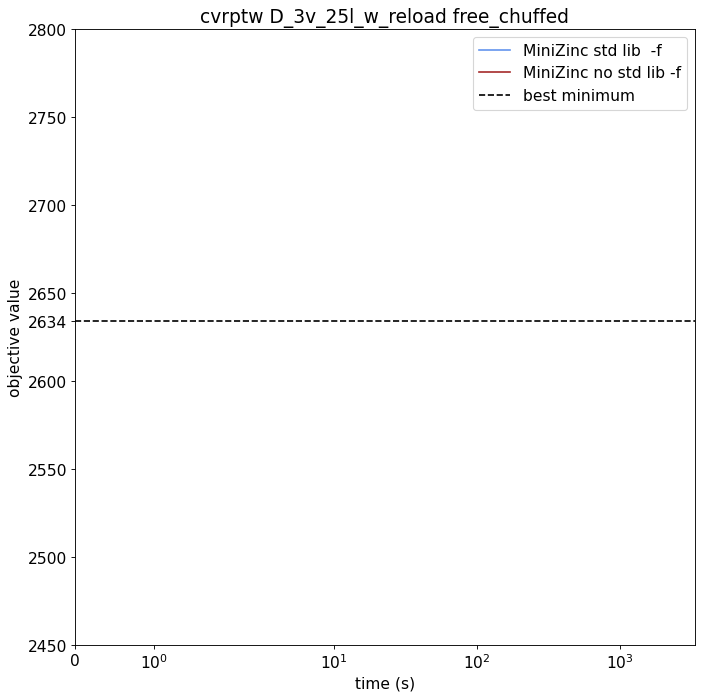

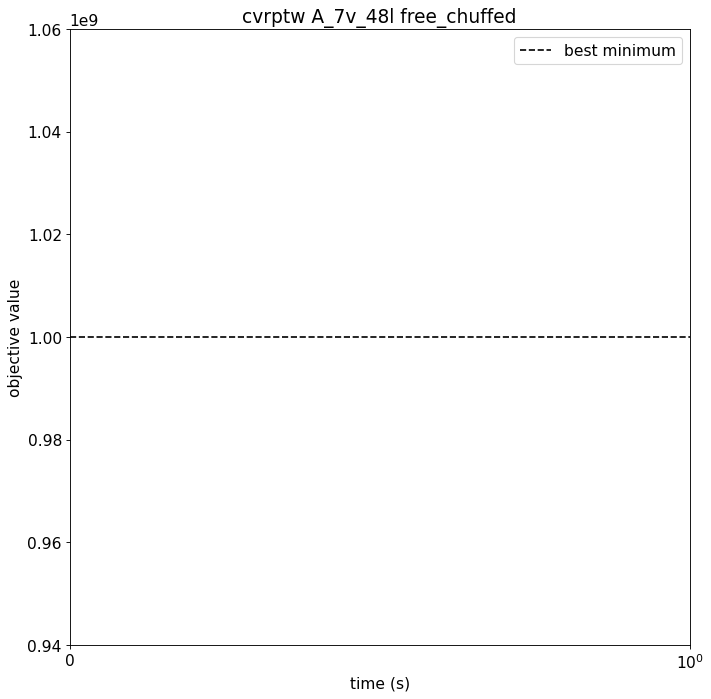

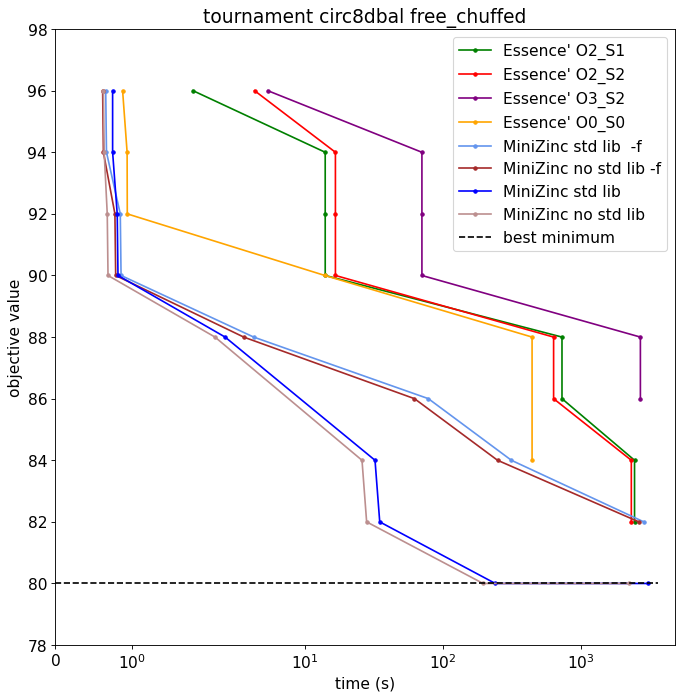

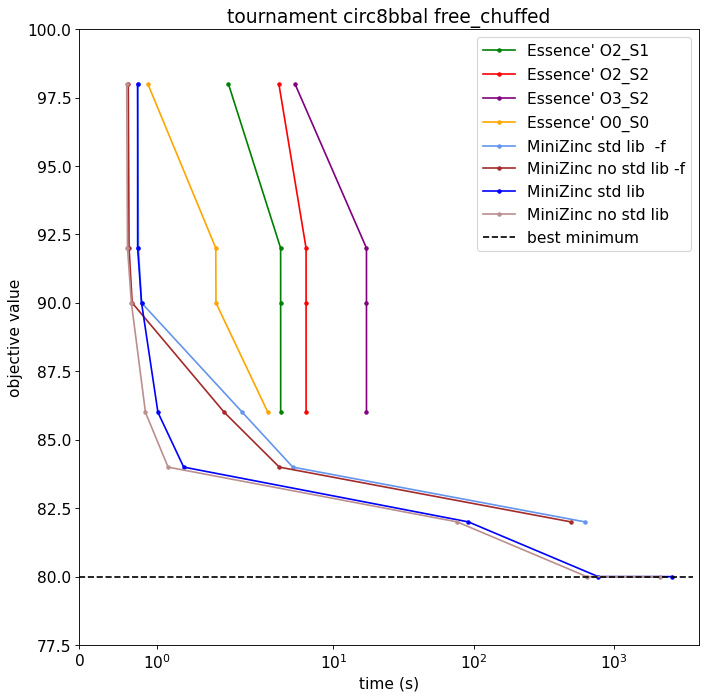

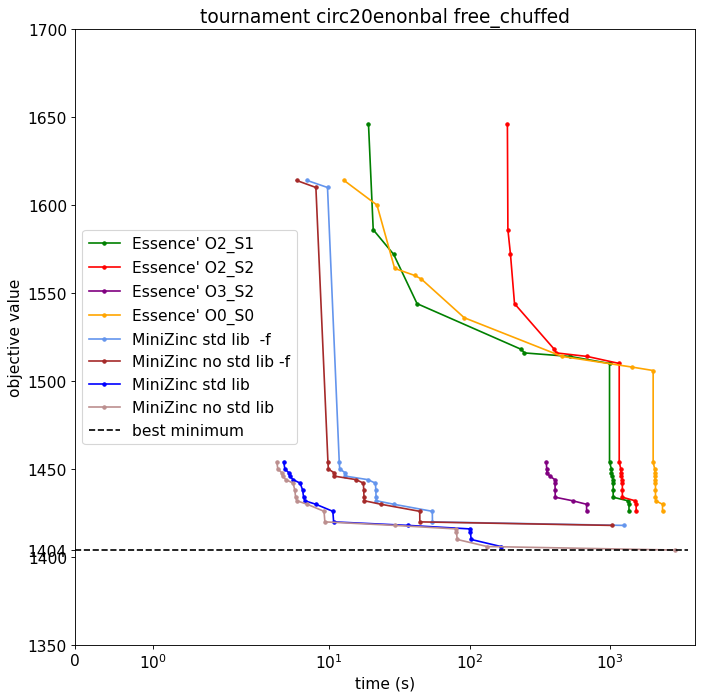

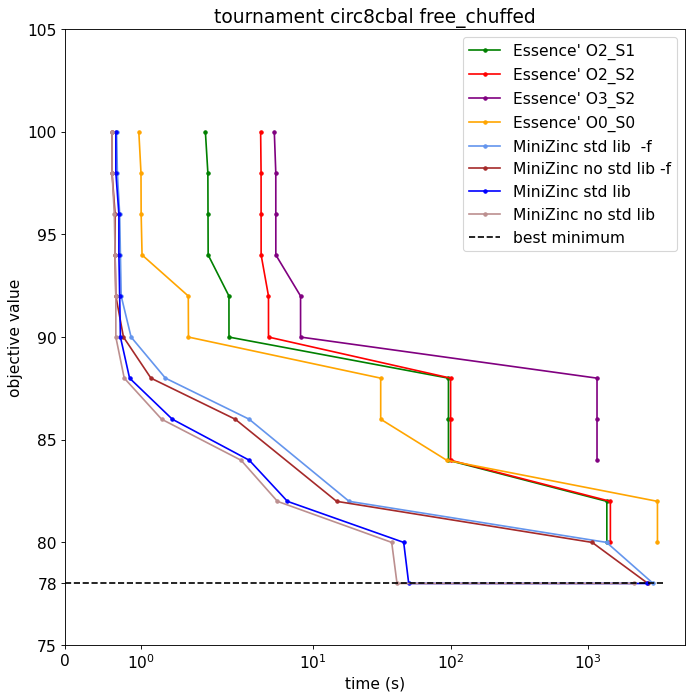

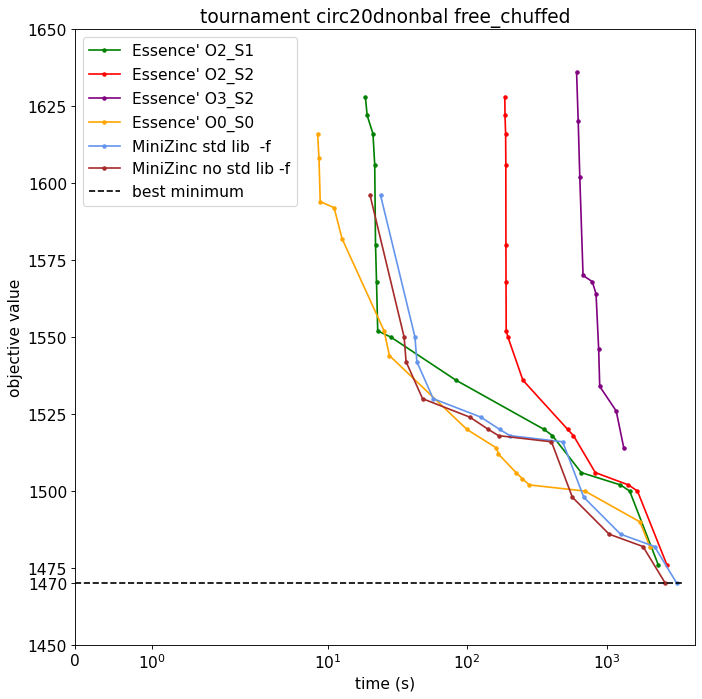

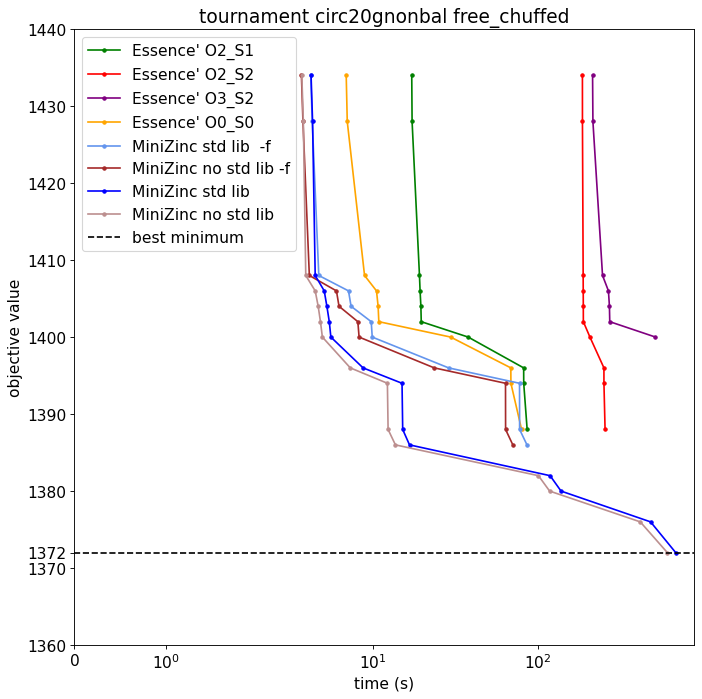

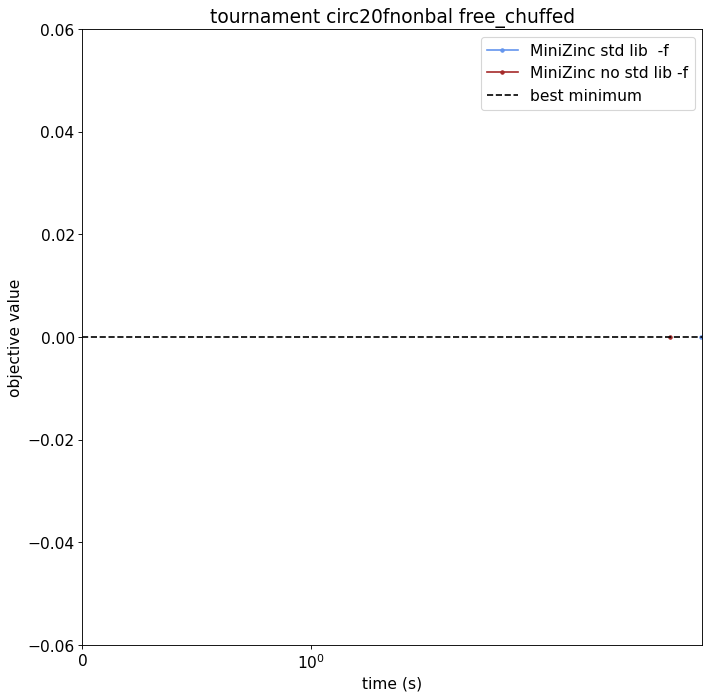

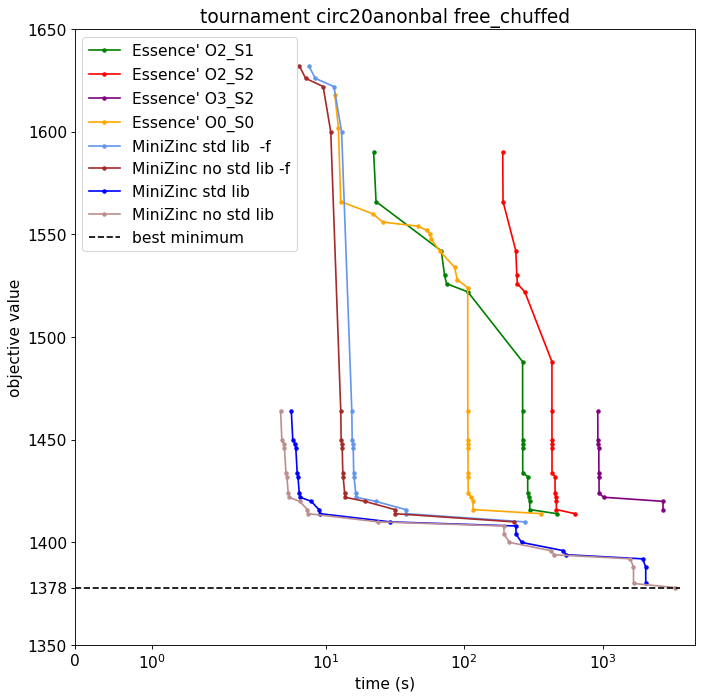

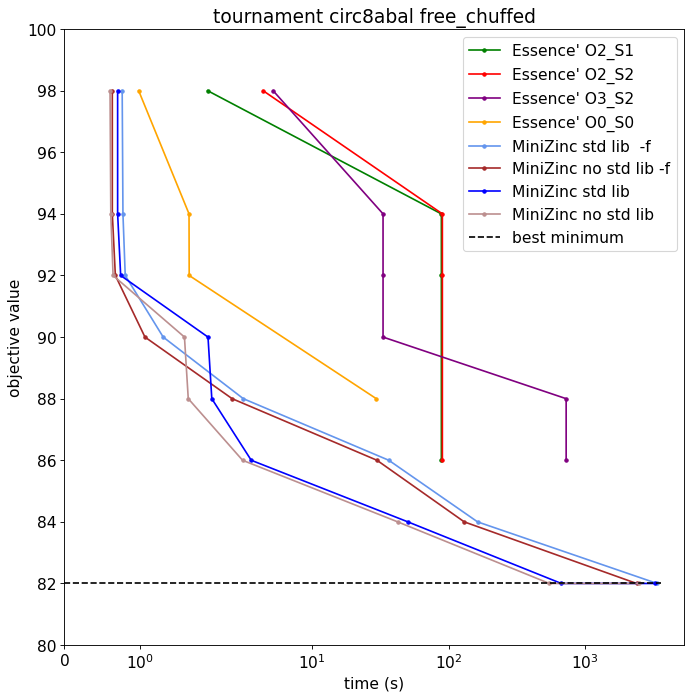

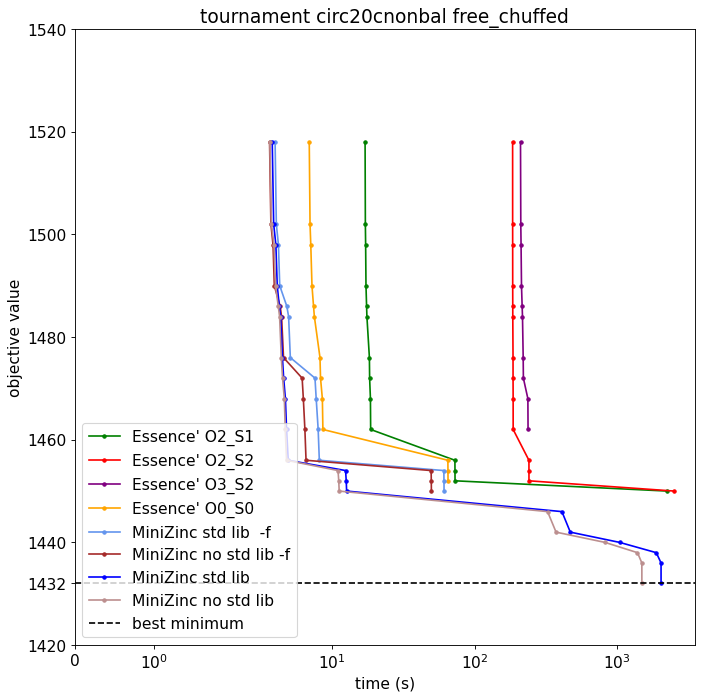

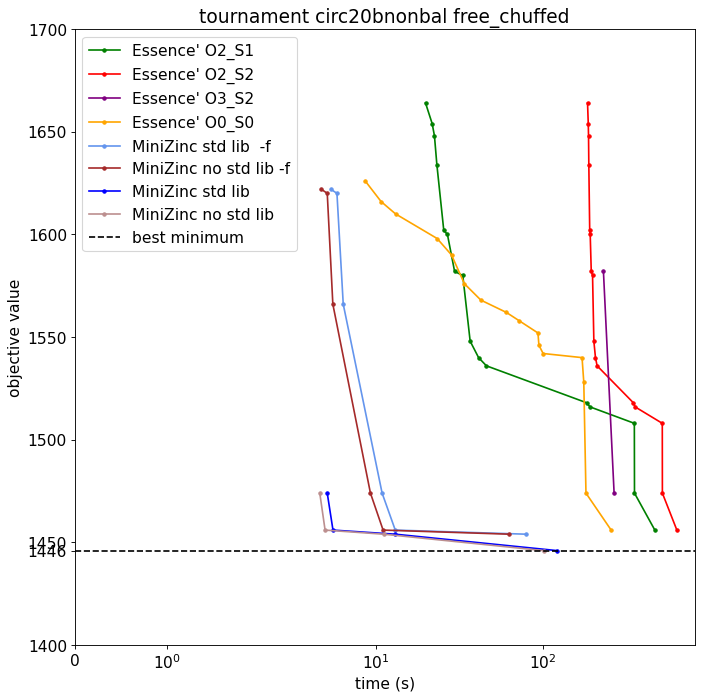

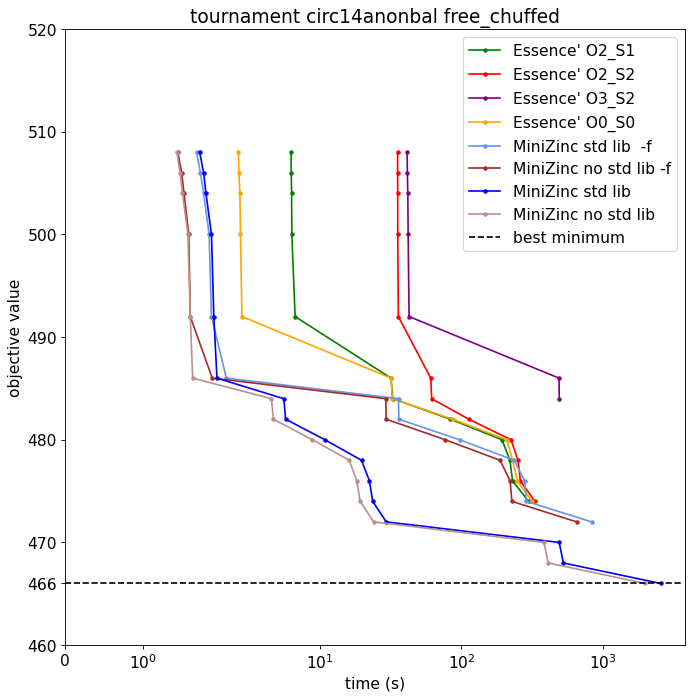

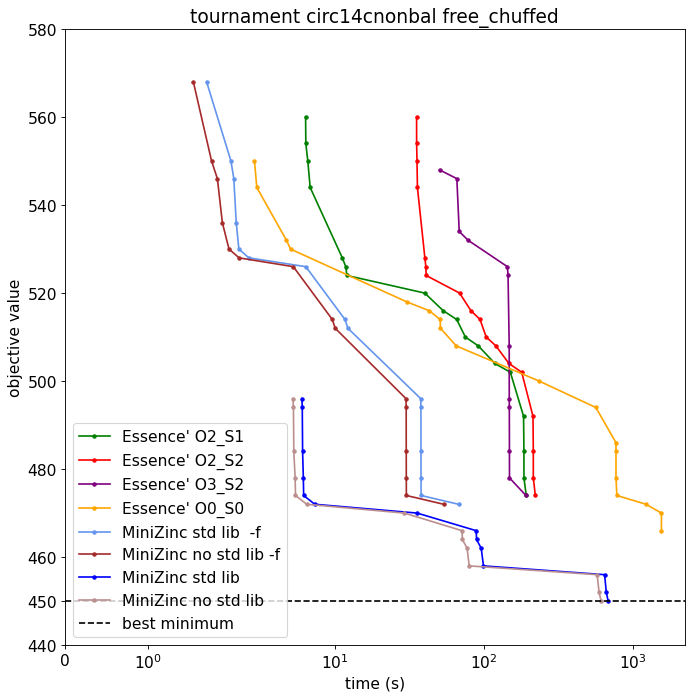

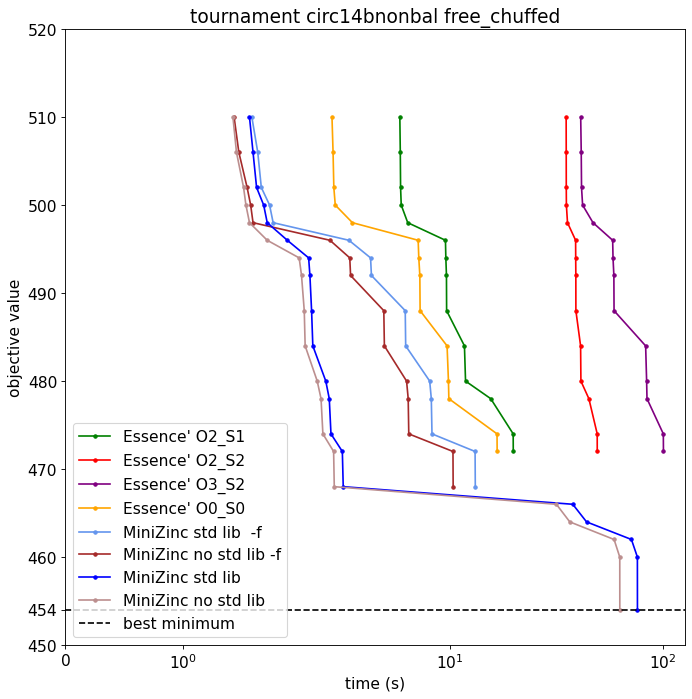

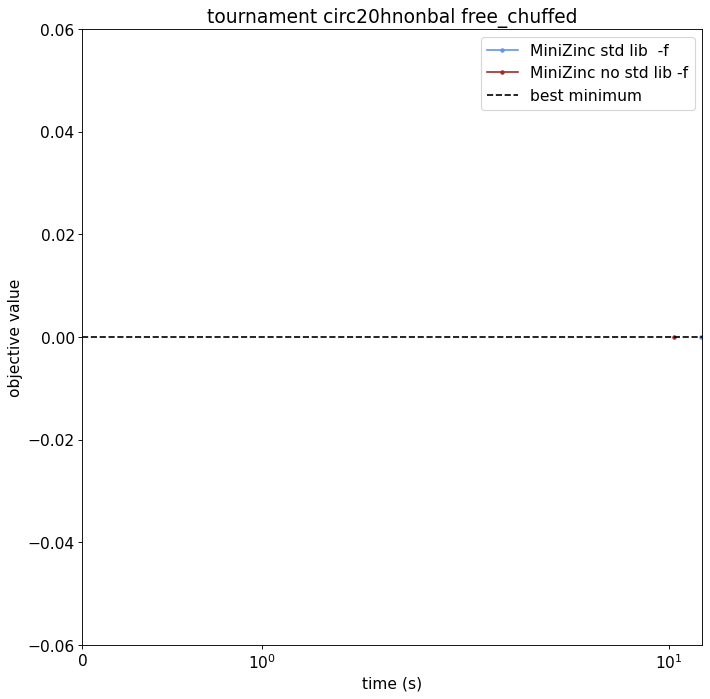

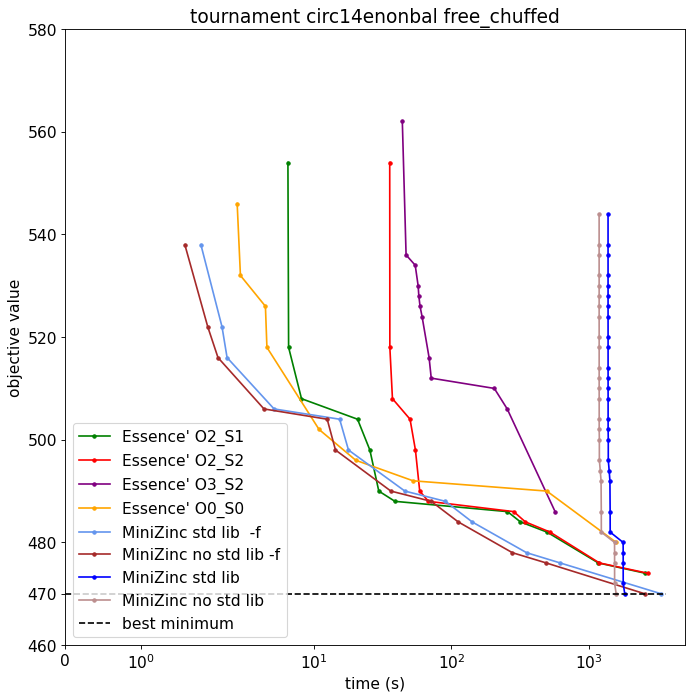

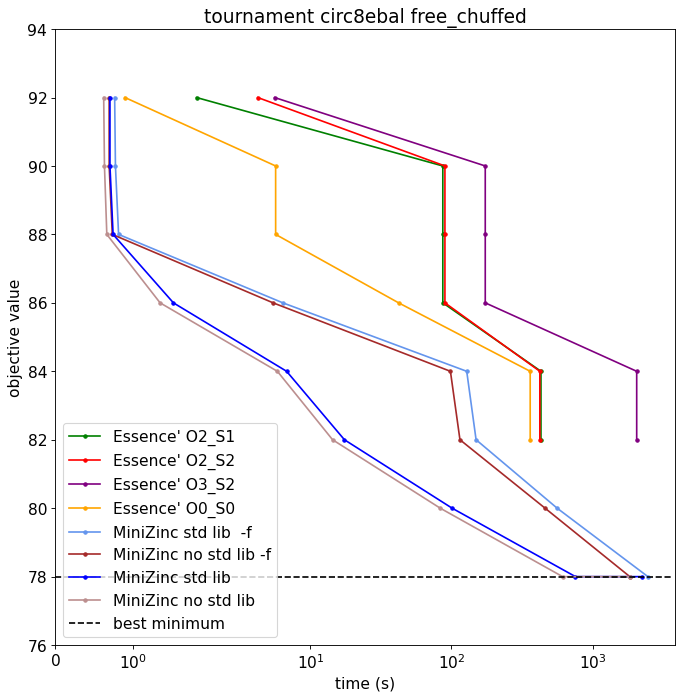

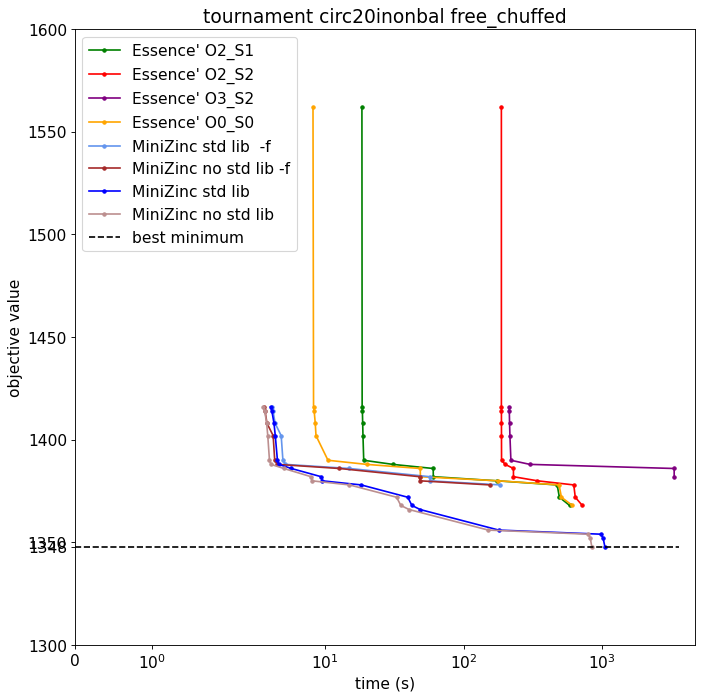

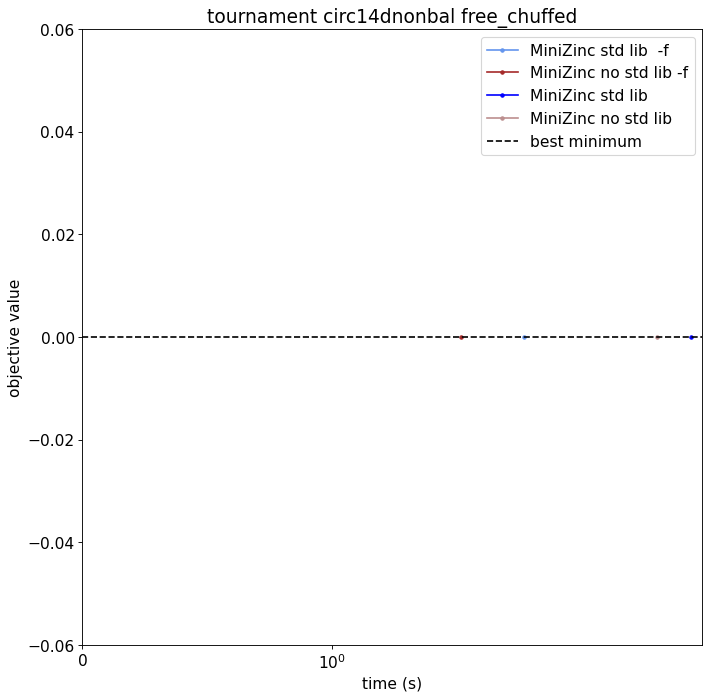

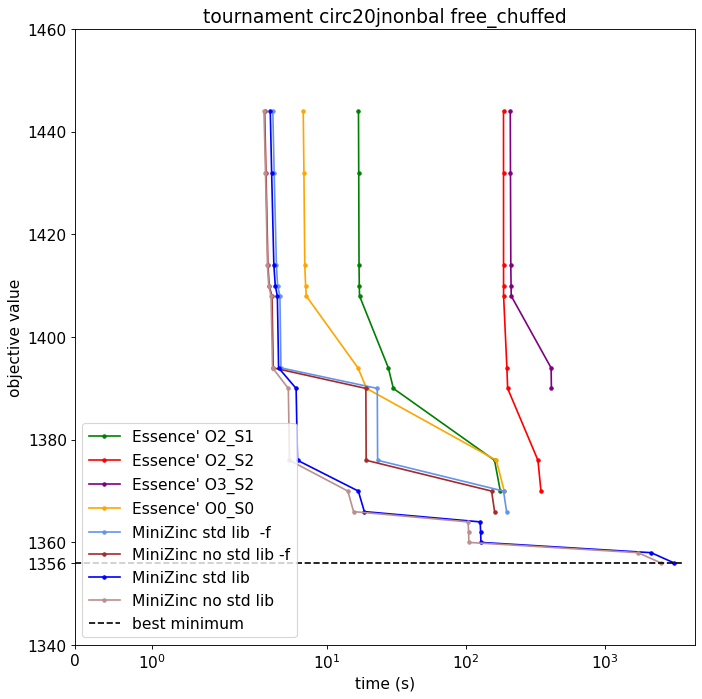

In [9]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import json
from ast import literal_eval
from pathlib import Path 
import statistics


problems = ["cvrptw", "tournament"]
data_location = "../../instances_and_solutions/"
objective_folder = "objective/"
objective_val_index = 0
timing_index = 1

median_run_num = 1
with open(str(Path().resolve()) + "/../../bash/constants/numberOfRuns.txt", "r") as num_runs_file:
    num_runs = num_runs_file.readline()
    median_run_num = int(literal_eval(num_runs)//2)
    
timeout_secs = 3600
with open(str(Path().resolve()) + "/../../bash/constants/timeout.txt", "r") as timeout_file:
    timeout_millisecs = timeout_file.readline()
    timeout_secs = int(literal_eval(timeout_millisecs)/1000)
print('timeout set in seconds as', timeout_secs)


def get_objective(line):
    line = line.replace(";\n", "")
    splt = line.split('=')
    return int(splt[-1])


# extracts objective values from minizinc file path
def process_minizinc_file(path):
    f = open(path)
    lines = f.readlines()
    res = [] # array of (objective values, timing)
    currObjective = 0
    for line in lines:
        if 'objective' in line:
            currObjective = get_objective(line)
        # ex "% time elapsed: 1868.99 s"
        if '% time' in line:
            line = line.replace("s\n", "")
            timing = float(line.split(':')[-1])
            if timing <= timeout_secs:
                res.append((currObjective, timing))
    return res

# gets the initialisation time for eprime problem in an ugly way
# the original data for eprime does not include the initialisation time
# because the flatzinc files from the models were reused to save recompiling them, 
# a mistake on my part given all optimisation or translation was done already, timings rectified here
def get_init_eprime(path):
    problem_location = 2
    instance_location = -1
    opt_location = 6
    path_split = path.split("/")
    instance_name = path_split[instance_location].split("_chuffed")[0]
    to_search = eprime_json[path_split[problem_location] + "_free_chuffed"][path_split[opt_location]]
    init_val = 0
    for tup in to_search:
        if tup[0] == instance_name:
            init_val = tup[-1]["initTime"]
            break
    return init_val

def process_eprime_file(path):
    init_val = get_init_eprime(path)
    f = open(path)
    lines = f.readlines()
    res = [] # array of (objective values, timing)
    currObjective = []
    prevLine = "" # used to capture timing info
    for line in lines:
        # objective is sum of prices, or objective
        if 'Price' in line or 'objective' in line:
            currObjective.append(get_objective(line))
        if '----------' in line:
            # add on initialisation value
            timing = float(prevLine)+init_val
            # only add objectives within timeout
            if timing <= timeout_secs:
                res.append((sum(currObjective), timing))  
            currObjective = []
        prevLine = line 
    return res

# get objective runs (ie. 3 runs), using either eprime or minizinc method
# sort runs based off of cumulative time to get median
def perform_runs(instance_path, method):
    runs = []
    for run in os.scandir(instance_path):
        runs.append(method(run.path))
    timing_sum = [sum([y[-1] for y in x]) for x in runs]
    runs = [x for _, x in sorted(zip(timing_sum, runs))]
    return runs

# dictionary format of
# mzn_vals[problem][(noF)free_solver][instanceName]
mzn_vals = {}
mzn_no_std_vals = {}

def extract_mzn(pathing):
    mzn_curr = {}
    for solvers in os.scandir(pathing):
        mzn_problem = {}
        for instance in os.scandir(solvers.path):
            runs = perform_runs(instance.path, process_minizinc_file)
            mzn_problem[instance.name] = runs[median_run_num] # middle run
        mzn_curr[solvers.name] = mzn_problem
    return mzn_curr

# def extract_init_eprime(opt, instance):



def extract_eprime(pathing):
    eprime_opt = {}
    for opt in os.scandir(pathing):
        eprime_instance = {}
        for instance in os.scandir(opt.path):
            runs = perform_runs(instance.path, process_eprime_file)
            instance_name = instance.name.split(".param")[0]
            eprime_instance[instance_name] = runs[median_run_num]
        eprime_opt[opt.name] = eprime_instance
    return eprime_opt

f = open('eprime_data.json')
eprime_json = json.load(f)

# format of dictionary
# eprime_vals[problem][solver][opt][instanceName]
eprime_vals = {}
for p in problems:
    mzn_vals[p] = extract_mzn(data_location + p + "/minizinc/objective")
    mzn_no_std_vals[p] = extract_mzn(data_location + p + "/minizinc/noStdLibObjective")
    eprime_curr = {}
    for solvers in os.scandir(data_location + p + "/eprime/"):
        if solvers.name == "param" or 'gecode' in solvers.name:
            continue
        print(solvers.name)
        eprime_curr[solvers.name] = extract_eprime(solvers.path + "/objective")
        # if "noFree_chuffed" in solvers.name:
        #     eprime_curr["free_chuffed"] = eprime_curr["noFree_chuffed"]
    eprime_vals[p] = eprime_curr


coloring = {}
coloring["O0_S0"] = "orange"
coloring["O2_S1"] = "green"
coloring["O2_S2"] = "red"
coloring["O3_S2"] = "purple" 
coloring["free_chuffed"] = "cornflowerblue"
coloring["noFree_chuffed"] = "blue"
coloring["free_chuffed noStdLib"] = "brown"
coloring["noFree_chuffed noStdLib"] = "rosybrown"



def setup_figure(problem, instance_name, solver):
    fig = figure(figsize=(10, 10), dpi=80)
    plt.rcParams['font.size'] = 14
    plt.title(problem + " " + instance_name.split(".")[0] + " " + solver)
    plt.xlabel("time (s)")
    plt.ylabel("objective value")
    plt.xscale("symlog")
    
    # plt.yscale("symlog")

# used to plot the global minimum objective of instance
curr_min_obj = 1000000000

def plot_eprime(p, solver, instance_name, marker):
    global curr_min_obj
    for opt in eprime_vals[p][solver]:
        eprime_data = eprime_vals[p][solver][opt][instance_name]
        if len(eprime_data) == 0:
            continue
        y_eprime =  [y[objective_val_index] for y in eprime_data]
        curr_min_obj = min(curr_min_obj, *y_eprime)
        plt.plot([x[timing_index] for x in eprime_data], y_eprime, label='Essence\' ' + opt, marker=marker, color=coloring[opt])

def plot_mzn(p, solver, instance_name, marker):
    global curr_min_obj
    curr_mzn = mzn_vals[p][solver][instance_name]
    no_std_lib = mzn_no_std_vals[p][solver][instance_name]
    y_curr_mzn = [y[0] for y in curr_mzn]
    y_no_std_lib = [y[0] for y in no_std_lib]
    if len(y_curr_mzn) == 0 and len(y_no_std_lib) == 0:
        return
    determine_total_obj(curr_mzn, no_std_lib)
    curr_min_obj = min(curr_min_obj, *y_curr_mzn, *y_no_std_lib)
    free_flag = '' if 'noFree' in solver else ' -f'
    plt.plot([x[timing_index] for x in curr_mzn], y_curr_mzn, label='MiniZinc std lib ' +  free_flag, marker=marker, color=coloring[solver])
    plt.plot([x[timing_index] for x in no_std_lib],y_no_std_lib, label='MiniZinc no std lib' + free_flag , marker=marker, color=coloring[solver + " noStdLib"])


total_mzn_last_obj = []


def determine_total_obj(curr_mzn, no_std_lib):
    global total_mzn_last_obj
    if len(curr_mzn) == 0 or len(no_std_lib) == 0:
        return
    if curr_mzn[-1][objective_val_index] == no_std_lib[-1][objective_val_index]:
        total_mzn_last_obj.append(curr_mzn[-1][timing_index]/no_std_lib[-1][timing_index])

for p in problems:
    for solver in eprime_vals[p].keys():
        if 'noFree' in solver:
            continue  
        for instance_name in mzn_vals[p][solver].keys(): 
            curr_min_obj = 1000000000
            marker = '.' if 'circ' in instance_name else None
            setup_figure(p, instance_name, solver)
            plot_eprime(p, solver, instance_name, marker)
            plot_mzn(p, "free_chuffed", instance_name, marker)
            plot_mzn(p, "noFree_chuffed", instance_name, marker)
            plt.xlim(left=0)
            # add in best minimum line and corresponding ytick on axes
            plt.plot([0, timeout_secs], [curr_min_obj, curr_min_obj], linestyle="--", color="black", label="best minimum")
            # add in min objective to yticks if not added
            yticks = list(plt.yticks()[0])
            if curr_min_obj not in yticks:
                yticks.append(curr_min_obj)
            plt.yticks(yticks)
            plt.legend()


1.2298430046330864
[1.21-1.25]


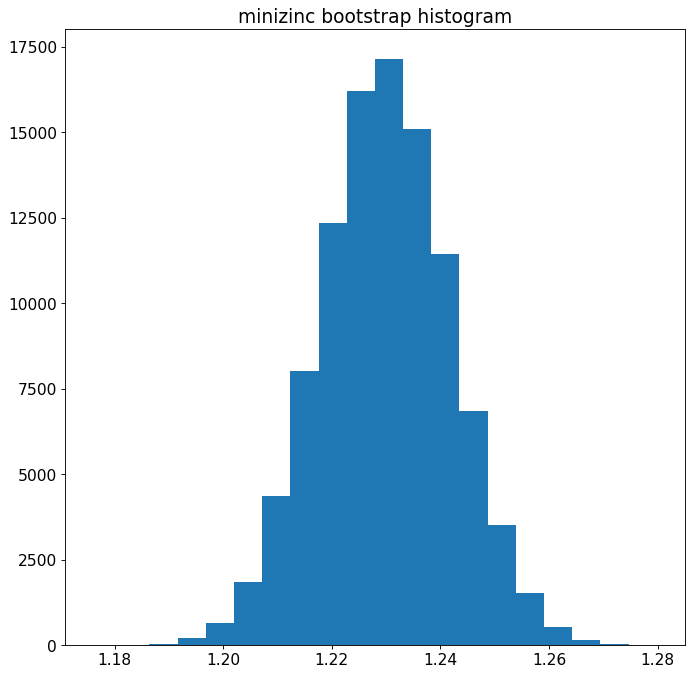

In [11]:
import numpy as np 
import random

def find_interval(lst):
    if len(lst) > 0:
        bell = []
        for i in range(100000):
            to_take = len(lst)
            y = random.choices(lst, k=to_take)
            avg = statistics.geometric_mean(y)
            bell.append(avg)
        figure(figsize=(10, 10), dpi=80)
        bell_sorted = sorted(bell)
        plt.title('minizinc bootstrap histogram')
        plt.hist(bell_sorted, bins = 20)
        left = np.quantile(bell, 0.025)
        right = np.quantile(bell, 0.975)
        # print(problem, opt, round(left,2), round(right,2), '----------------- OUT OF RANGE' if left <= 1 and right >= 1 else '')
        return('[' + str(round(left,2)) + "-" + str(round(right,2)) + ']')
    return '[1-1]'


print(statistics.geometric_mean(total_mzn_last_obj))
print(find_interval(total_mzn_last_obj))